# 1) Import packages

In [1]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from Fairea.utility import get_data,write_to_file
from Fairea.fairea import create_baseline,normalize,get_classifier,classify_region,compute_area
from shapely.geometry import Polygon, Point, LineString
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 12})

# 2) Generate baseline

In [2]:
dataset_used = "adult"
attr = "sex"
clf_name = "lr"
degrees = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
mutation_strategies = {"0":[1,0],"1":[0,1]}
dataset_orig, privileged_groups,unprivileged_groups,optim_options = get_data(dataset_used, attr)

In [3]:
res = create_baseline(clf_name,dataset_orig, privileged_groups,unprivileged_groups,
                    data_splits=10,repetitions=10,odds=mutation_strategies,options = [0,1],
                   degrees = degrees)

Obtain accuray (index 0 of each row) and fairness (SPD is index 1, AOD is index 2) for each overwriting strategy

In [4]:
acc0 = np.array([np.mean([row[0] for row in res["0"][degree]]) for degree in degrees])
acc1 = np.array([np.mean([row[0] for row in res["1"][degree]]) for degree in degrees])

spd0 = np.array([np.mean([row[1] for row in res["0"][degree]]) for degree in degrees])
spd1 = np.array([np.mean([row[1] for row in res["1"][degree]]) for degree in degrees])

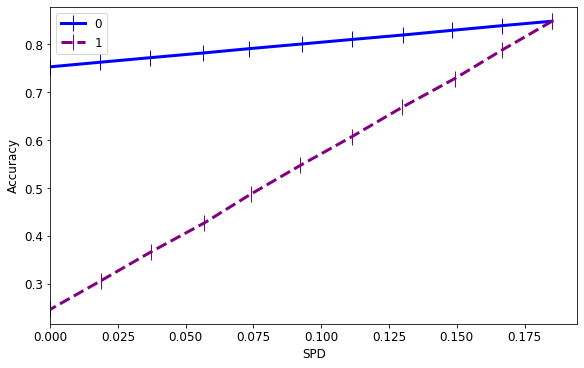

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5),constrained_layout=True)
axes.plot(spd0,acc0,color="blue",marker = "|", linestyle = "solid",linewidth=3,markersize=16)
axes.plot(spd1,acc1,color="purple",marker = "|", linestyle = "dashed",linewidth=3,markersize=16)
axes.set_xlim(0)
axes.set_xlabel("SPD")
axes.set_ylabel("Accuracy")
axes.legend(mutation_strategies.keys())

Among those two strategies, "0" is the stricter (higher accuracy for identical value of SPD) and will be used in the following

# 3) Display bias mitigation methods

We use experimental data from bias mitigation methods generated with the AIF360 framework. For each bias mitigation method, "data" reports accuracy and SPD averaged over 50 different data splits.

In [6]:
data = """cpp_fpr 0.82157588 0.10589097 
cpp-fpr 0.83472396 0.26558595
cpp-weighed 0.83472396 0.26558595 
eqo 0.82001474 0.09288338 
lfr 0.77271025 0.10578446 
op 0.79025456 0.09252048 
rw 0.78917082 0.06518951 
roc-spd 0.78664259 0.0479941  
roc-aod 0.80177342 0.2120785  
roc-eod 0.79531363 0.27394755 
"""

methods = dict()
for line in data.splitlines():
    name,acc,spd = line.split()
    methods[name] = (float(acc),float(spd))

Text(0, 0.5, 'Accuracy')

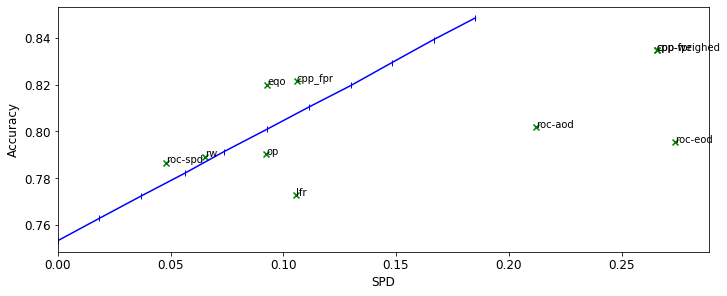

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4),constrained_layout=True)
axes.plot(spd0, acc0,color="blue",marker = "|")

axes.scatter([x[1] for x in methods.values()],[x[0] for x in methods.values()],marker="x",color="green")
for k,v in methods.items():
    axes.annotate(k, (v[1], v[0]), fontsize=10)
axes.set_xlim(0)
axes.set_xlabel("SPD")
axes.set_ylabel("Accuracy")
#plt.show()

# 4) Determine mitigation region
To determine the mitigation region of bias mitigation methods, we perform three steps:

1. Normalize the data
2. Determine region
3. Compute area of "good trade-off region"

## 4-1) Normalize data

In [8]:
normalized_accuracy, normalized_fairness, normalized_methods = normalize(acc0,spd0,methods)

Text(0, 0.5, 'Accuracy')

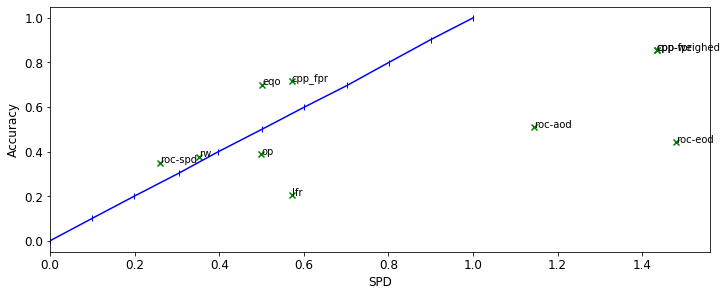

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4),constrained_layout=True)
axes.plot(normalized_fairness, normalized_accuracy,color="blue",marker = "|")

axes.scatter([x[1] for x in normalized_methods.values()],[x[0] for x in normalized_methods.values()],marker="x",color="green")
for k,v in normalized_methods.items():
    axes.annotate(k, (v[1], v[0]), fontsize=10)
axes.set_xlim(0)
axes.set_xlabel("SPD")
axes.set_ylabel("Accuracy")
#plt.show()

## 4-2) Mitigation Region

In [10]:
# Transform baseline to geometric shape with shapely
baseline = LineString([(x,y) for x, y in zip(normalized_fairness,normalized_accuracy)])
regions = classify_region(baseline, normalized_methods)
regions

{'cpp_fpr': 'good trade-off',
 'cpp-fpr': 'lose-lose',
 'cpp-weighed': 'lose-lose',
 'eqo': 'good trade-off',
 'lfr': 'bad trade-off',
 'op': 'bad trade-off',
 'rw': 'good trade-off',
 'roc-spd': 'good trade-off',
 'roc-aod': 'lose-lose',
 'roc-eod': 'lose-lose'}

## 4-3) Determine area
Before determining the area, we filter methods for the "good trade-off" region

In [11]:
good = {k for k,v in regions.items() if v == "good trade-off"}
normalized_methods = {k:v for k,v in normalized_methods.items() if k in good}
good,normalized_methods

({'cpp_fpr', 'eqo', 'roc-spd', 'rw'},
 {'cpp_fpr': (0.7169104279544931, 0.5718511583870921),
  'eqo': (0.7005185183654513, 0.501605268588138),
  'rw': (0.37665855192322634, 0.3520479301321626),
  'roc-spd': (0.35011223475737213, 0.2591862335451827)})

In [12]:
for k,v in normalized_methods.items():
    area = compute_area(baseline,v)
    print (k,area)

cpp_fpr 0.010978364091501342
eqo 0.02022852966390566
rw 0.00028441041981653155
roc-spd 0.004188009791490697
